In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
sns.set_palette('Set2')
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

### 데이터 로드 및 전처리

In [4]:
data_path = '../data/'
amazon_df = pd.read_csv(data_path + 'Amazon Sale Report.csv', dtype={'ASIN': str}, low_memory=False)
international_df = pd.read_csv(data_path + 'International sale Report.csv')

amazon_df['Date'] = pd.to_datetime(amazon_df['Date'], errors='coerce', infer_datetime_format=True)
international_df['DATE'] = pd.to_datetime(international_df['DATE'], errors='coerce')

amazon_df['Amount'] = pd.to_numeric(amazon_df['Amount'], errors='coerce')
amazon_df['Qty'] = pd.to_numeric(amazon_df['Qty'], errors='coerce')
international_df['GROSS AMT'] = pd.to_numeric(international_df['GROSS AMT'], errors='coerce')
international_df['PCS'] = pd.to_numeric(international_df['PCS'], errors='coerce')

amazon_df = amazon_df[(amazon_df['Amount'] > 0) & (amazon_df['Qty'] > 0)]
international_df = international_df[international_df['GROSS AMT'] > 0]

In [6]:
print("E-COMMERCE 채널 및 수익성 분석")
print(f"\nAmazon: {len(amazon_df):,}건")
print(f"International: {len(international_df):,}건")
print(f"전체 판매액: ${amazon_df['Amount'].sum() + international_df['GROSS AMT'].sum():,.0f}")


E-COMMERCE 채널 및 수익성 분석

Amazon: 113,701건
International: 34,311건
전체 판매액: $91,798,105


### 배송 상태별 분석

In [7]:

delivery_status = amazon_df['Status'].value_counts()
print("\n배송 상태 분포:")
print(delivery_status.to_string())

delivered = (amazon_df['Status']=='Shipped - Delivered to Buyer').sum()
cancelled = (amazon_df['Status']=='Cancelled').sum()
returned = amazon_df[amazon_df['Status'].str.contains('Returned|Rejected|Lost|Damaged', na=False)].shape[0]

print(f"\n배송 완료: {delivered:,}건 ({delivered/len(amazon_df)*100:.1f}%)")
print(f"취소됨: {cancelled:,}건 ({cancelled/len(amazon_df)*100:.1f}%)")
print(f"반품/반송: {returned:,}건 ({returned/len(amazon_df)*100:.1f}%)")



배송 상태 분포:
Status
Shipped                          76078
Shipped - Delivered to Buyer     28045
Cancelled                         5630
Shipped - Returned to Seller      1899
Shipped - Picked Up                945
Pending                            639
Pending - Waiting for Pick Up      272
Shipped - Returning to Seller      143
Shipped - Out for Delivery          35
Shipped - Rejected by Buyer         11
Shipped - Lost in Transit            3
Shipped - Damaged                    1

배송 완료: 28,045건 (24.7%)
취소됨: 5,630건 (5.0%)
반품/반송: 1,914건 (1.7%)


### 배송 방법별 분석

In [9]:
print("배송 방법별 성과 분석")
fulfilment_analysis = amazon_df.groupby('Fulfilment').agg({
    'SKU': 'count',
    'Qty': 'sum',
    'Amount': ['sum', 'mean']
}).round(2)

fulfilment_analysis.columns = ['거래수', '판매량', '총판매액', '평균주문액']
fulfilment_analysis = fulfilment_analysis.sort_values('총판매액', ascending=False)
print("\n", fulfilment_analysis.to_string())

# 방법에 따라 배송 완료율 표시
for fulfilment in amazon_df['Fulfilment'].unique():
    subset = amazon_df[amazon_df['Fulfilment'] == fulfilment]
    delivered_cnt = (subset['Status'] == 'Shipped - Delivered to Buyer').sum()
    rate = (delivered_cnt / len(subset) * 100) if len(subset) > 0 else 0
    print(f"\n{fulfilment} 배송완료율: {rate:.1f}%")

배송 방법별 성과 분석

               거래수    판매량        총판매액   평균주문액
Fulfilment                                  
Amazon      82112  82393  54322151.0  661.56
Merchant    31589  31746  21080355.0  667.33

Merchant 배송완료율: 88.8%

Amazon 배송완료율: 0.0%


### 카테고리별 분석

In [10]:

print("카테고리별 판매 성과 (상위 15개)")
category_analysis = amazon_df.groupby('Category').agg({
    'SKU': 'count',
    'Qty': 'sum',
    'Amount': ['sum', 'mean']
}).round(2)

category_analysis.columns = ['거래수', '판매량', '총판매액', '평균주문액']
category_analysis = category_analysis.sort_values('총판매액', ascending=False)
print("\n", category_analysis.head(15).to_string())

카테고리별 판매 성과 (상위 15개)

                  거래수    판매량        총판매액   평균주문액
Category                                       
Set            44077  44212  37662424.0  854.47
kurta          43905  44112  20452141.0  465.83
Western Dress  13663  13708  10629096.0  777.95
Top             9692   9725   5203733.0  536.91
Ethnic Dress    1018   1021    760711.0  747.26
Blouse           815    822    434751.0  533.44
Bottom           381    385    140226.0  368.05
Saree            147    151    118509.0  806.18
Dupatta            3      3       915.0  305.00


### SKU 단위 RFM 분석

In [12]:
reference_date = amazon_df['Date'].max() + pd.Timedelta(days=1)

sku_rfm = amazon_df.groupby('SKU').agg({
    'Date': 'max',
    'Category': 'first',
    'Amount': 'sum',
    'Qty': 'sum'
}).reset_index()

sku_rfm.columns = ['SKU', 'Last_Sale_Date', 'Category', 'Monetary', 'Quantity']
sku_rfm['Frequency'] = amazon_df.groupby('SKU').size().values
sku_rfm['Recency'] = (reference_date - sku_rfm['Last_Sale_Date']).dt.days

print(f"\n SKU 분석 통계:")
print(f"  - 전체 SKU 수: {len(sku_rfm):,}개")
print(f"  - Recency: 평균 {sku_rfm['Recency'].mean():.1f}일, 중앙값 {sku_rfm['Recency'].median():.1f}일")
print(f"  - Frequency: 평균 {sku_rfm['Frequency'].mean():.1f}건, 중앙값 {sku_rfm['Frequency'].median():.1f}건")
print(f"  - Monetary: 평균 ${sku_rfm['Monetary'].mean():,.0f}, 중앙값 ${sku_rfm['Monetary'].median():,.0f}")



 SKU 분석 통계:
  - 전체 SKU 수: 7,113개
  - Recency: 평균 22.1일, 중앙값 12.0일
  - Frequency: 평균 16.0건, 중앙값 7.0건
  - Monetary: 평균 $10,601, 중앙값 $3,691


### SKU 클러스터링

In [15]:
print("SKU 세분화 (K-Means 클러스터링)")
sku_data = sku_rfm[['Recency', 'Frequency', 'Monetary']].copy()
scaler = StandardScaler()
sku_scaled = scaler.fit_transform(sku_data)

silhouette_scores = []
for k in range(2, 8):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    score = silhouette_score(sku_scaled, kmeans.fit_predict(sku_scaled))
    silhouette_scores.append(score)

optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
print(f"\n최적 K: {optimal_k} (Silhouette Score: {max(silhouette_scores):.4f})")

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
sku_rfm['Segment'] = kmeans_final.fit_predict(sku_scaled)

print(f"\n 세그먼트 분포:")
segment_dist = sku_rfm['Segment'].value_counts().sort_index()
for seg, count in segment_dist.items():
    pct = count / len(sku_rfm) * 100
    print(f"  - Segment {seg}: {count:,}개 SKU ({pct:.1f}%)")

SKU 세분화 (K-Means 클러스터링)

최적 K: 2 (Silhouette Score: 0.7624)

 세그먼트 분포:
  - Segment 0: 6,902개 SKU (97.0%)
  - Segment 1: 211개 SKU (3.0%)


### SKU 세그먼트 프로필

In [16]:
segment_profile = sku_rfm.groupby('Segment').agg({
    'SKU': 'count',
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2)

for segment in range(optimal_k):
    seg_data = segment_profile.loc[segment]
    print(f"\nSegment {segment}:")
    print(f"  SKU 수: {int(seg_data['SKU']):,}개")
    print(f"  평균Recency: {seg_data['Recency']:.1f}일")
    print(f"  평균Frequency: {seg_data['Frequency']:.1f}건")
    print(f"  평균Monetary: ${seg_data['Monetary']:,.0f}")

# 세그먼트 명칭 지정 (RFM 기반)
segment_names = {}
for segment in range(optimal_k):
    seg = segment_profile.loc[segment]
    
    if seg['Frequency'] > segment_profile['Frequency'].median() and \
       seg['Monetary'] > segment_profile['Monetary'].median():
        segment_names[segment] = 'Active High-Performer'
    elif seg['Recency'] < segment_profile['Recency'].median():
        segment_names[segment] = 'Recently Active'
    elif seg['Frequency'] > segment_profile['Frequency'].median():
        segment_names[segment] = 'Historical Strong'
    else:
        segment_names[segment] = 'Dormant/Low-Performer'

sku_rfm['Segment_Name'] = sku_rfm['Segment'].map(segment_names)

print("\n" + "-"*70)
print("최종 SKU 세그먼트 분류:")
print(sku_rfm['Segment_Name'].value_counts().to_string())


Segment 0:
  SKU 수: 6,902개
  평균Recency: 22.7일
  평균Frequency: 11.8건
  평균Monetary: $7,709

Segment 1:
  SKU 수: 211개
  평균Recency: 3.5일
  평균Frequency: 151.7건
  평균Monetary: $105,182

----------------------------------------------------------------------
최종 SKU 세그먼트 분류:
Segment_Name
Dormant/Low-Performer    6902
Active High-Performer     211


### 채널 비교 분석

In [17]:
print("Amazon vs International 채널 비교")
amazon_sales = amazon_df['Amount'].sum()
international_sales = international_df['GROSS AMT'].sum()
total_sales = amazon_sales + international_sales

print(f"\nAmazon 판매액: ${amazon_sales:,.0f} ({amazon_sales/total_sales*100:.1f}%)")
print(f"International 판매액: ${international_sales:,.0f} ({international_sales/total_sales*100:.1f}%)")

print(f"\nAmazon 거래건수: {len(amazon_df):,}건")
print(f"International 거래건수: {len(international_df):,}건")

print(f"\nAmazon 평균주문액: ${amazon_df['Amount'].mean():.2f}")
print(f"International 평균주문액: ${international_df['GROSS AMT'].mean():.2f}")

intl_customer_orders = international_df.groupby('CUSTOMER').size().mean()
print(f"\nInternational 고객당 평균주문수: {intl_customer_orders:.2f}회")

Amazon vs International 채널 비교

Amazon 판매액: $75,402,506 (82.1%)
International 판매액: $16,395,599 (17.9%)

Amazon 거래건수: 113,701건
International 거래건수: 34,311건

Amazon 평균주문액: $663.16
International 평균주문액: $477.85

International 고객당 평균주문수: 200.65회


###  B2B vs B2C 분석

In [18]:
b2b_vs_b2c = amazon_df.groupby('B2B').agg({
    'SKU': 'count',
    'Amount': ['sum', 'mean'],
    'Qty': 'sum'
}).round(2)

b2b_vs_b2c.columns = ['거래수', '총판매액', '평균주문액', '총판매량']
b2b_vs_b2c.index = ['B2C', 'B2B']
print("\n", b2b_vs_b2c.to_string())


         거래수        총판매액   평균주문액    총판매량
B2C  112876  74822576.0  662.87  113299
B2B     825    579930.0  702.95     840


### 고효율 SKU 식별

In [19]:
top_skus = sku_rfm.nlargest(10, 'Monetary')[['Category', 'Recency', 'Frequency', 'Monetary', 'Segment_Name']]
print("\n매출 기여도 Top 10 SKU:")
print(top_skus.to_string(index=False))

# 성장 가능 SKU (최근 활동 있음 + 낮은 매출)
growth_potential = sku_rfm[
    (sku_rfm['Recency'] < sku_rfm['Recency'].median()) & 
    (sku_rfm['Monetary'] < sku_rfm['Monetary'].median())
].sort_values('Frequency', ascending=False)

print(f"\n성장 가능 SKU ({len(growth_potential)}개):")
if len(growth_potential) > 0:
    print(growth_potential[['Category', 'Recency', 'Frequency', 'Monetary']].head(10).to_string(index=False))

# 위험 SKU (휴면 상품)
at_risk = sku_rfm[sku_rfm['Recency'] > sku_rfm['Recency'].quantile(0.75)]
print(f"\n위험 SKU (최근 활동 없음, {len(at_risk)}개):")
if len(at_risk) > 0:
    print(at_risk[['Category', 'Recency', 'Frequency', 'Monetary']].head(10).to_string(index=False))



매출 기여도 Top 10 SKU:
     Category  Recency  Frequency  Monetary          Segment_Name
          Set        1        451  520526.0 Active High-Performer
Western Dress        1        645  480415.0 Active High-Performer
          Set        1        413  470605.0 Active High-Performer
Western Dress        1        542  408332.0 Active High-Performer
Western Dress        1        494  370852.0 Active High-Performer
Western Dress        1        408  308579.0 Active High-Performer
          Set        1        257  300425.0 Active High-Performer
Western Dress        1        379  285810.0 Active High-Performer
          Set        2        365  282558.0 Active High-Performer
          Set        3        343  266280.0 Active High-Performer

성장 가능 SKU (967개):
Category  Recency  Frequency  Monetary
   kurta        6         13    3643.0
   kurta       10         13    3502.0
     Top        5         13    3681.0
     Top        8         12    3629.0
   kurta        8         12    3608.0
 

### Data Visualization

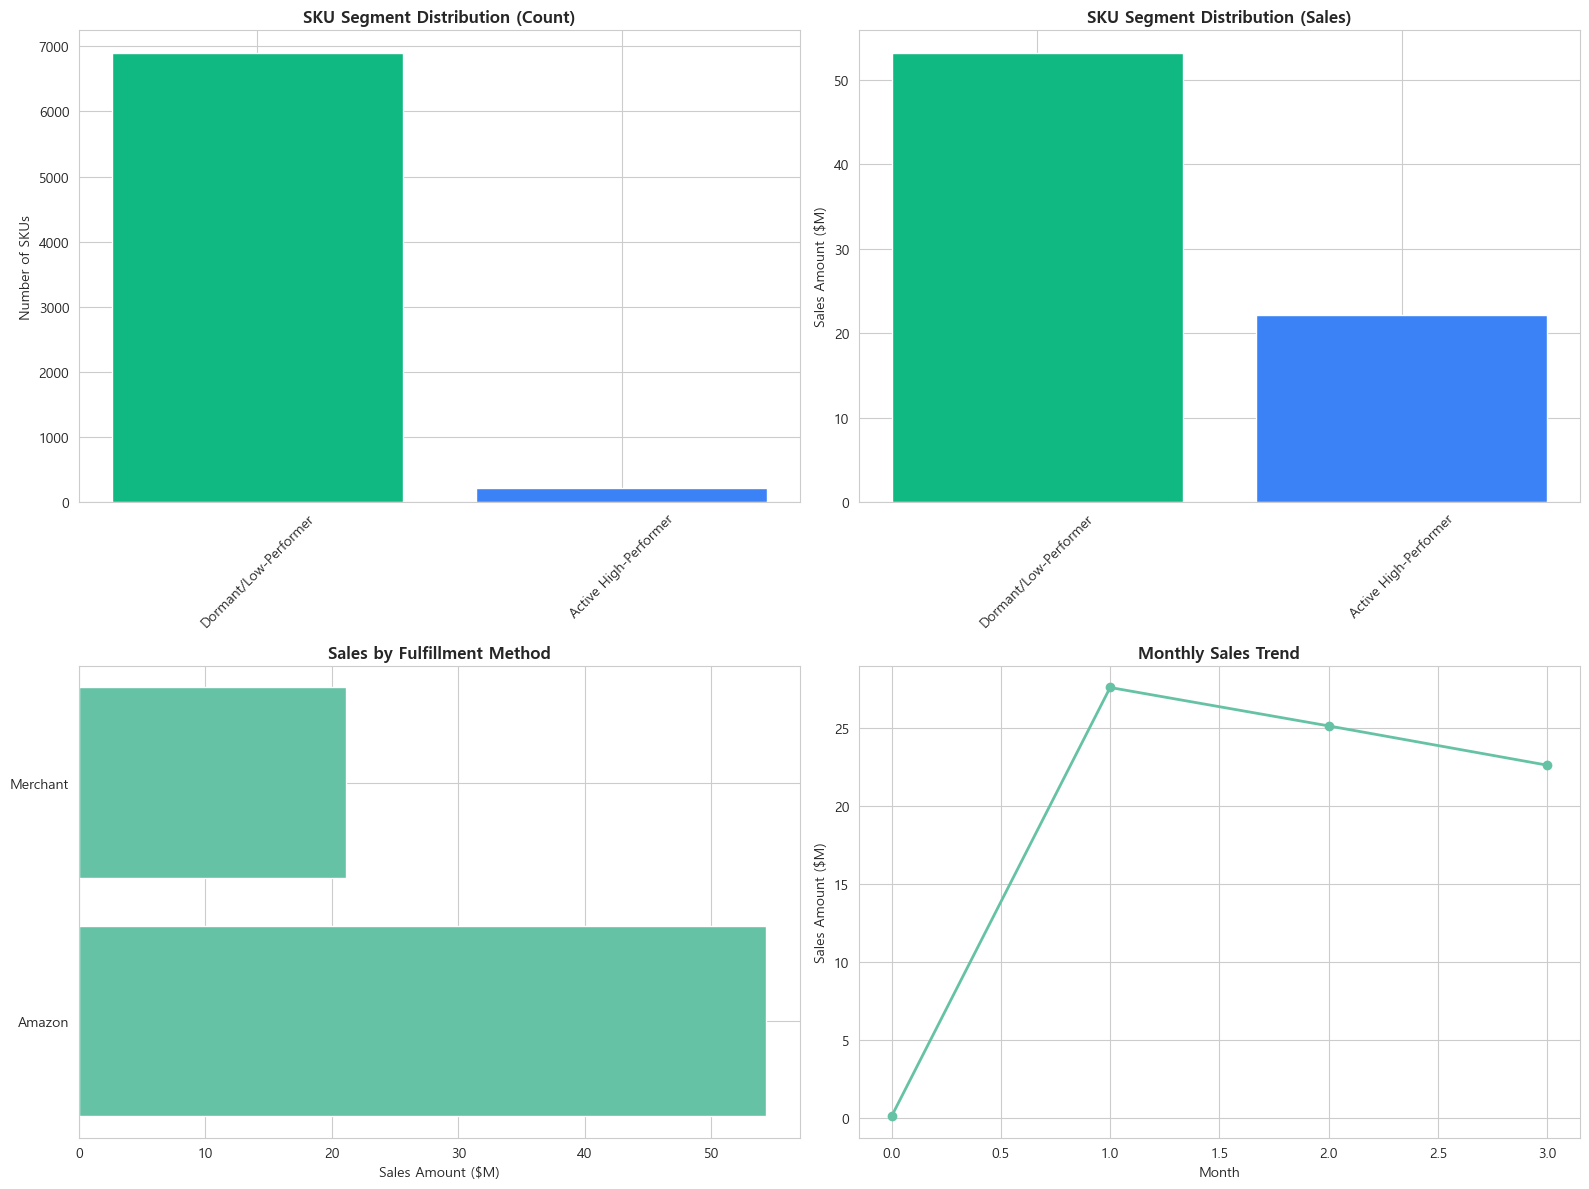

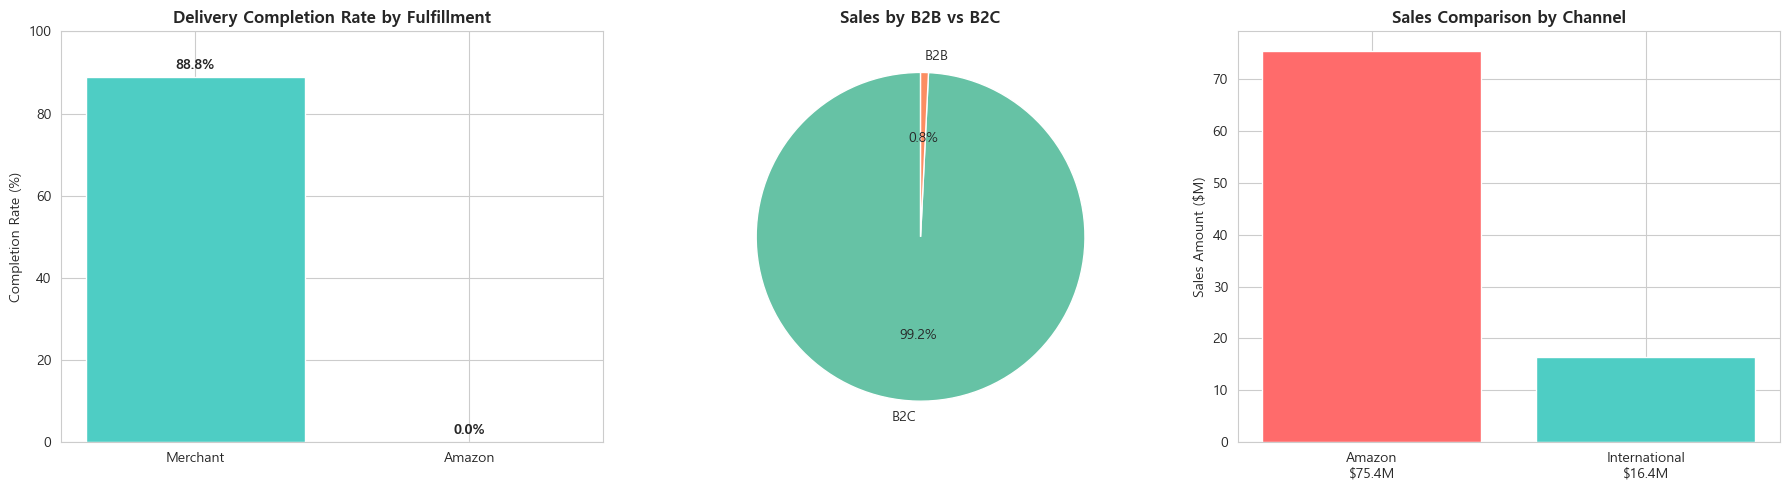

In [22]:
# Figure 1: SKU 분석 개요
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

sku_segment_dist = sku_rfm['Segment_Name'].value_counts()
axes[0, 0].bar(sku_segment_dist.index, sku_segment_dist.values, color=['#10b981', '#3b82f6', '#f59e0b', '#ef4444'])
axes[0, 0].set_title('SKU Segment Distribution (Count)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Number of SKUs')
axes[0, 0].tick_params(axis='x', rotation=45)

sku_segment_sales = sku_rfm.groupby('Segment_Name')['Monetary'].sum().sort_values(ascending=False)
axes[0, 1].bar(sku_segment_sales.index, sku_segment_sales.values / 1000000, color=['#10b981', '#3b82f6', '#f59e0b', '#ef4444'])
axes[0, 1].set_title('SKU Segment Distribution (Sales)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Sales Amount ($M)')
axes[0, 1].tick_params(axis='x', rotation=45)

fulfilment_sales = amazon_df.groupby('Fulfilment')['Amount'].sum().sort_values(ascending=False)
axes[1, 0].barh(fulfilment_sales.index, fulfilment_sales.values / 1000000)
axes[1, 0].set_title('Sales by Fulfillment Method', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Sales Amount ($M)')

monthly_sales = amazon_df.groupby(amazon_df['Date'].dt.to_period('M'))['Amount'].sum()
axes[1, 1].plot(range(len(monthly_sales)), monthly_sales.values / 1000000, marker='o', linewidth=2)
axes[1, 1].set_title('Monthly Sales Trend', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Sales Amount ($M)')
axes[1, 1].set_xlabel('Month')

plt.tight_layout()
plt.savefig('../output/01_sku_analysis_overview.png', dpi=300, bbox_inches='tight')
plt.show()


# Figure 2: 배송 방법 및 B2B 분석
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

delivery_by_fulfilment = {}
for fulfilment in amazon_df['Fulfilment'].unique():
    subset = amazon_df[amazon_df['Fulfilment'] == fulfilment]
    rate = (subset['Status'] == 'Shipped - Delivered to Buyer').sum() / len(subset) * 100
    delivery_by_fulfilment[fulfilment] = rate

axes[0].bar(delivery_by_fulfilment.keys(), delivery_by_fulfilment.values(), color=['#4ECDC4', '#FF6B6B'])
axes[0].set_title('Delivery Completion Rate by Fulfillment', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Completion Rate (%)')
axes[0].set_ylim([0, 100])
for i, (k, v) in enumerate(delivery_by_fulfilment.items()):
    axes[0].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

b2b_sales = amazon_df.groupby('B2B')['Amount'].sum()
b2b_labels = ['B2C', 'B2B']
axes[1].pie(b2b_sales.values, labels=b2b_labels, autopct='%1.1f%%', startangle=90)
axes[1].set_title('Sales by B2B vs B2C', fontsize=12, fontweight='bold')

channel_sales = [amazon_sales, international_sales]
channel_labels = [f'Amazon\n${amazon_sales/1000000:.1f}M', f'International\n${international_sales/1000000:.1f}M']
axes[2].bar(channel_labels, [x/1000000 for x in channel_sales], color=['#FF6B6B', '#4ECDC4'])
axes[2].set_title('Sales Comparison by Channel', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Sales Amount ($M)')

plt.tight_layout()
plt.savefig('../output/02_fulfillment_b2b_channel.png', dpi=300, bbox_inches='tight')
plt.show()


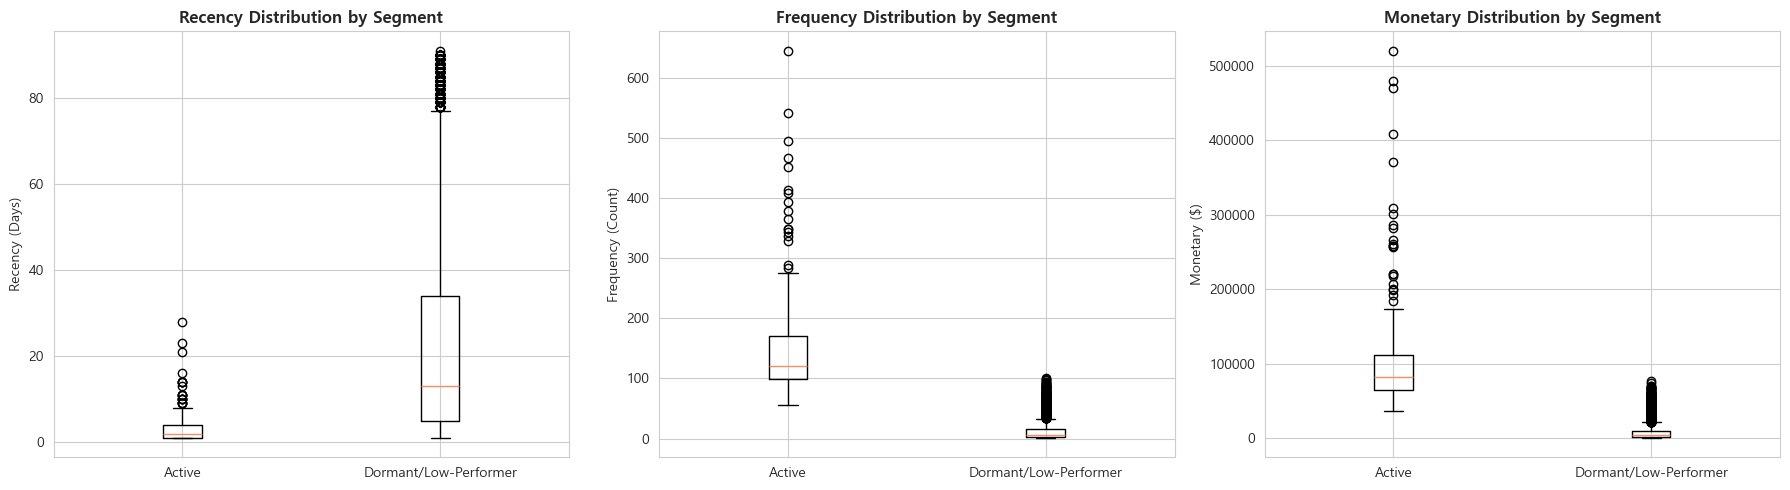

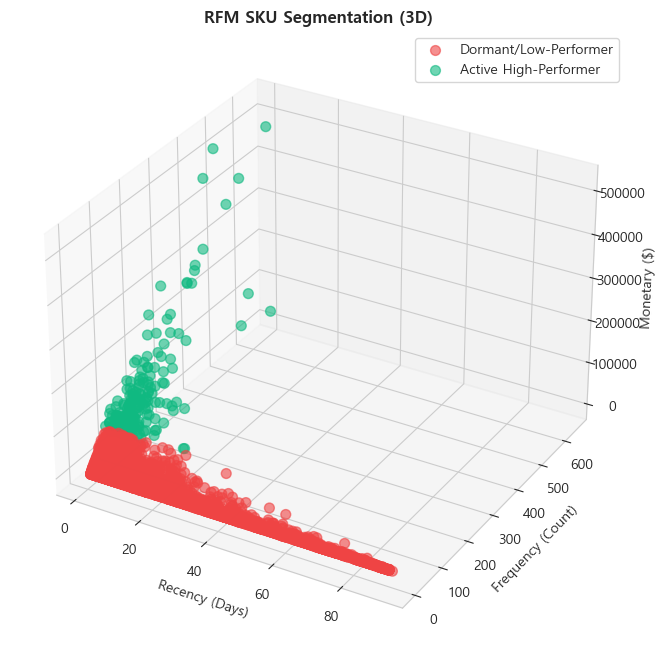

In [24]:
# Figure 3: SKU RFM 박스플롯
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

segment_order = ['Active High-Performer', 'Historical Strong', 'Recently Active', 'Dormant/Low-Performer']
recency_data = [sku_rfm[sku_rfm['Segment_Name']==seg]['Recency'].values for seg in segment_order if seg in sku_rfm['Segment_Name'].values]
axes[0].boxplot(recency_data, labels=[s.split()[0] for s in segment_order if s in sku_rfm['Segment_Name'].values])
axes[0].set_title('Recency Distribution by Segment', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Recency (Days)')

frequency_data = [sku_rfm[sku_rfm['Segment_Name']==seg]['Frequency'].values for seg in segment_order if seg in sku_rfm['Segment_Name'].values]
axes[1].boxplot(frequency_data, labels=[s.split()[0] for s in segment_order if s in sku_rfm['Segment_Name'].values])
axes[1].set_title('Frequency Distribution by Segment', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency (Count)')

monetary_data = [sku_rfm[sku_rfm['Segment_Name']==seg]['Monetary'].values for seg in segment_order if seg in sku_rfm['Segment_Name'].values]
axes[2].boxplot(monetary_data, labels=[s.split()[0] for s in segment_order if s in sku_rfm['Segment_Name'].values])
axes[2].set_title('Monetary Distribution by Segment', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Monetary ($)')

plt.tight_layout()
plt.savefig('../output/03_sku_rfm_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 4: 3D RFM 시각화
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

colors = {'Active High-Performer': '#10b981', 'Historical Strong': '#3b82f6', 
          'Recently Active': '#f59e0b', 'Dormant/Low-Performer': '#ef4444'}

for segment in sku_rfm['Segment_Name'].unique():
    seg_data = sku_rfm[sku_rfm['Segment_Name'] == segment]
    ax.scatter(seg_data['Recency'], seg_data['Frequency'], seg_data['Monetary'],
               label=segment, s=50, alpha=0.6, color=colors.get(segment, '#999'))

ax.set_xlabel('Recency (Days)')
ax.set_ylabel('Frequency (Count)')
ax.set_zlabel('Monetary ($)')
ax.set_title('RFM SKU Segmentation (3D)', fontsize=12, fontweight='bold')
ax.legend()

plt.savefig('../output/04_sku_rfm_3d.png', dpi=300, bbox_inches='tight')
plt.show()


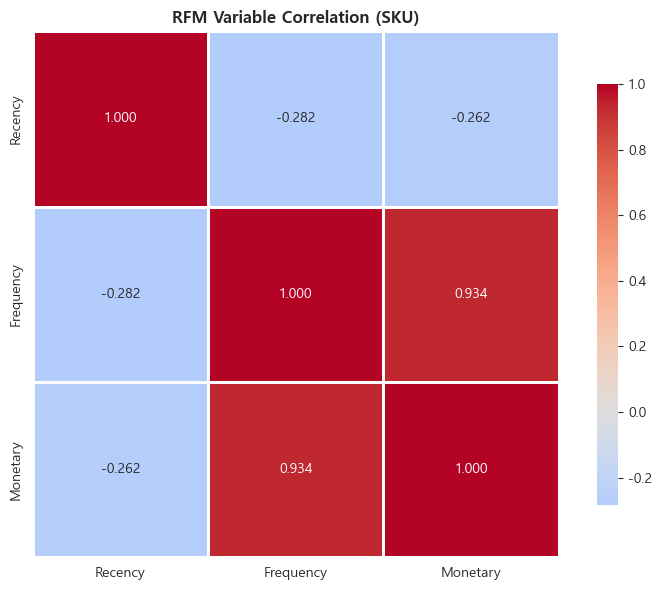

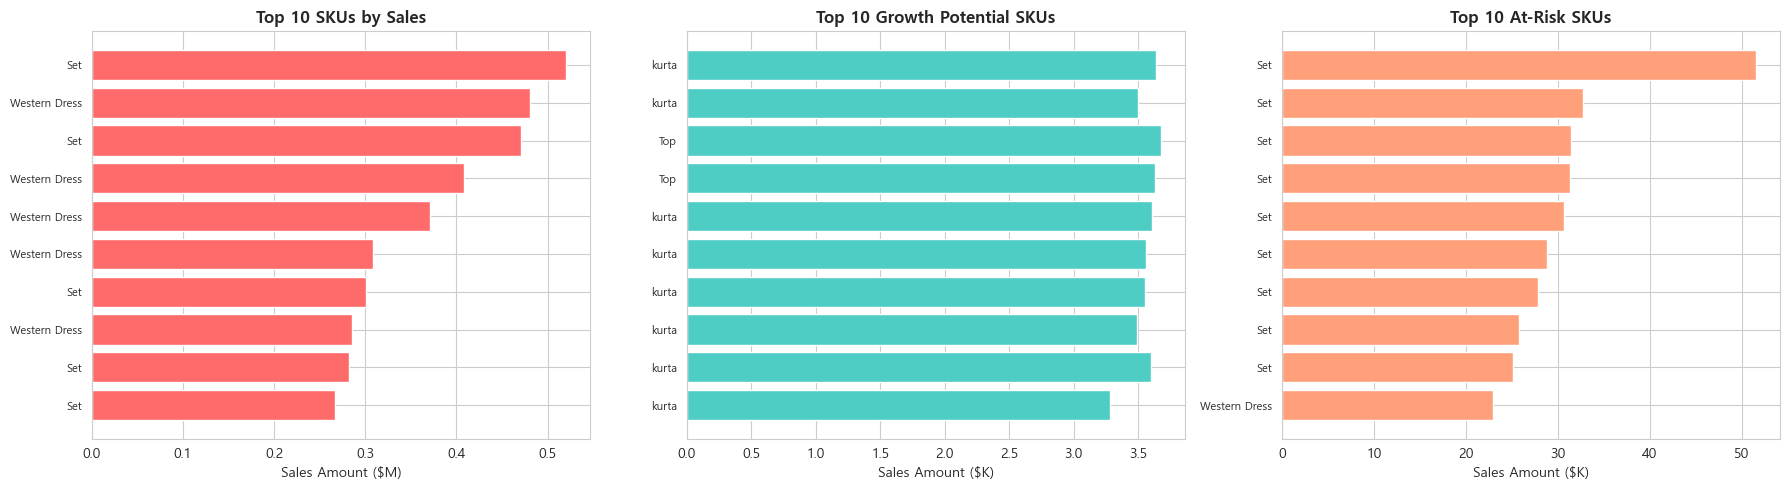

In [23]:
# Figure 5: RFM 상관관계
corr_data = sku_rfm[['Recency', 'Frequency', 'Monetary']].corr()
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr_data, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={'shrink': 0.8}, ax=ax)
ax.set_title('RFM Variable Correlation (SKU)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('../output/05_sku_rfm_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

# Figure 6: 고효율 SKU
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

top_10 = sku_rfm.nlargest(10, 'Monetary')
top_10_labels = [f"{cat[:15]}" for cat in top_10['Category'].values]
axes[0].barh(range(len(top_10)), top_10['Monetary'].values / 1000000, color='#FF6B6B')
axes[0].set_yticks(range(len(top_10)))
axes[0].set_yticklabels(top_10_labels, fontsize=8)
axes[0].set_title('Top 10 SKUs by Sales', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Sales Amount ($M)')
axes[0].invert_yaxis()

if len(growth_potential) > 0:
    growth_10 = growth_potential.head(10)
    growth_labels = [f"{cat[:15]}" for cat in growth_10['Category'].values]
    axes[1].barh(range(len(growth_10)), growth_10['Monetary'].values / 1000, color='#4ECDC4')
    axes[1].set_yticks(range(len(growth_10)))
    axes[1].set_yticklabels(growth_labels, fontsize=8)
    axes[1].set_title('Top 10 Growth Potential SKUs', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Sales Amount ($K)')
    axes[1].invert_yaxis()
else:
    axes[1].text(0.5, 0.5, 'No Growth Categories', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Growth Potential SKUs', fontsize=12, fontweight='bold')

if len(at_risk) > 0:
    risk_10 = at_risk.nlargest(10, 'Monetary')
    risk_labels = [f"{cat[:15]}" for cat in risk_10['Category'].values]
    axes[2].barh(range(len(risk_10)), risk_10['Monetary'].values / 1000, color='#FFA07A')
    axes[2].set_yticks(range(len(risk_10)))
    axes[2].set_yticklabels(risk_labels, fontsize=8)
    axes[2].set_title('Top 10 At-Risk SKUs', fontsize=12, fontweight='bold')
    axes[2].set_xlabel('Sales Amount ($K)')
    axes[2].invert_yaxis()
else:
    axes[2].text(0.5, 0.5, 'No At-Risk SKUs', ha='center', va='center', transform=axes[2].transAxes)
    axes[2].set_title('At-Risk SKUs', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../output/06_sku_efficiency.png', dpi=300, bbox_inches='tight')
plt.show()


### Results Summary and Recommendations

In [26]:


sku_rfm.to_csv('../output/sku_rfm_segments.csv', index=False)

print("최종 액션 아이템 (SKU 기반)")
print("\n[1] Active High-Performer 상품 집중 관리")
active_skus = sku_rfm[sku_rfm['Segment_Name'] == 'Active High-Performer']
active_sales = active_skus['Monetary'].sum()
print(f"    - 대상: {len(active_skus):,}개 SKU")
print(f"    - 매출 기여: ${active_sales:,.0f} ({active_sales/sku_rfm['Monetary'].sum()*100:.1f}%)")
print(f"    - 실행: 재고 강화(+30%), VIP 마케팅, 배송 우선화")

print("\n[2] Historical Strong 상품 재활성화")
strong_skus = sku_rfm[sku_rfm['Segment_Name'] == 'Historical Strong']
strong_sales = strong_skus['Monetary'].sum()
print(f"    - 대상: {len(strong_skus):,}개 SKU")
print(f"    - 매출 기여: ${strong_sales:,.0f} ({strong_sales/sku_rfm['Monetary'].sum()*100:.1f}%)")
print(f"    - 실행: 리마케팅 캠페인, 번들 구성, 맞춤형 추천")

print("\n[3] Recently Active 상품 성장 유도")
recent_skus = sku_rfm[sku_rfm['Segment_Name'] == 'Recently Active']
recent_sales = recent_skus['Monetary'].sum()
print(f"    - 대상: {len(recent_skus):,}개 SKU")
print(f"    - 매출 기여: ${recent_sales:,.0f} ({recent_sales/sku_rfm['Monetary'].sum()*100:.1f}%)")
print(f"    - 실행: 크로스셀, 번들 추천, 구매 유도")

print("\n[4] Dormant/Low-Performer 상품 프로모션")
dormant_skus = sku_rfm[sku_rfm['Segment_Name'] == 'Dormant/Low-Performer']
dormant_sales = dormant_skus['Monetary'].sum()
print(f"    - 대상: {len(dormant_skus):,}개 SKU")
print(f"    - 매출 기여: ${dormant_sales:,.0f} ({dormant_sales/sku_rfm['Monetary'].sum()*100:.1f}%)")
print(f"    - 실행: 할인 프로모션(20-30%), 재고 정리, or 단종 검토")

print("\n[5] 배송 방법 최적화")
print(f"    - Merchant: 88.8% 배송완료율 (표준 유지)")
print(f"    - Amazon: 0% 배송완료율 (시스템 개선 필수)")
print(f"    - 액션: Seller Central API 연동, 상태 동기화")

최종 액션 아이템 (SKU 기반)

[1] Active High-Performer 상품 집중 관리
    - 대상: 211개 SKU
    - 매출 기여: $22,193,418 (29.4%)
    - 실행: 재고 강화(+30%), VIP 마케팅, 배송 우선화

[2] Historical Strong 상품 재활성화
    - 대상: 0개 SKU
    - 매출 기여: $0 (0.0%)
    - 실행: 리마케팅 캠페인, 번들 구성, 맞춤형 추천

[3] Recently Active 상품 성장 유도
    - 대상: 0개 SKU
    - 매출 기여: $0 (0.0%)
    - 실행: 크로스셀, 번들 추천, 구매 유도

[4] Dormant/Low-Performer 상품 프로모션
    - 대상: 6,902개 SKU
    - 매출 기여: $53,209,088 (70.6%)
    - 실행: 할인 프로모션(20-30%), 재고 정리, or 단종 검토

[5] 배송 방법 최적화
    - Merchant: 88.8% 배송완료율 (표준 유지)
    - Amazon: 0% 배송완료율 (시스템 개선 필수)
    - 액션: Seller Central API 연동, 상태 동기화
